In [29]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, UpSampling2D
from sklearn.model_selection import train_test_split

In [19]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path="mnist.npz")

#### sample data

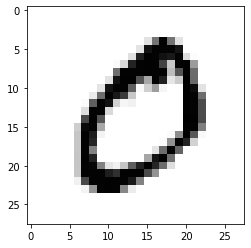

In [20]:
plt.imshow(x_train[1], cmap='Greys')

#### add noise

In [21]:
noise_factor = 0.25
x_train_noisy = x_train + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor*np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

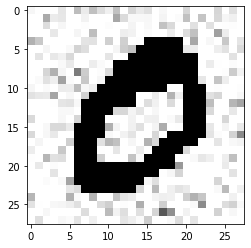

In [22]:
plt.imshow(x_train_noisy[1], cmap='Greys')

#### dataset dimensions

In [23]:
print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [24]:
print(y_train.shape)
print(y_test.shape)

(60000,)
(10000,)


#### reshaping

In [25]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_train.shape)
print(x_test.shape)
x_train_noisy = x_train_noisy.reshape(x_train_noisy.shape[0], 28, 28, 1)
x_test_noisy = x_test_noisy.reshape(x_test_noisy.shape[0], 28, 28, 1)
print(x_train_noisy.shape)
print(x_test_noisy.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


#### normalizing

In [26]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
x_train_noisy = x_train_noisy.astype('float32')
x_test_noisy = x_test_noisy.astype('float32')
x_train_noisy /= 255
x_test_noisy /= 255

#### noise removal using an auto encoder

In [27]:
auto_encoder = Sequential()
auto_encoder.add(Conv2D(28, kernel_size=(7,7), activation=tf.nn.relu, padding='same', input_shape=(28, 28, 1)))
auto_encoder.add(MaxPooling2D(pool_size=(2, 2)))
auto_encoder.add(Conv2D(14, kernel_size=(7,7), activation=tf.nn.relu, padding='same'))
auto_encoder.add(MaxPooling2D(pool_size=(2, 2)))
auto_encoder.add(Conv2D(14, kernel_size=(7,7), activation=tf.nn.relu, padding='same'))
auto_encoder.add(UpSampling2D())
auto_encoder.add(Conv2D(28, kernel_size=(7,7), activation=tf.nn.relu, padding='same'))
auto_encoder.add(UpSampling2D())
auto_encoder.add(Conv2D(1, kernel_size=(7,7), activation=tf.nn.sigmoid, padding='same'))

In [28]:
auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

#### noise removal

In [30]:
X_noise_train, X_noise_valid, X_train, X_valid = train_test_split(x_train_noisy, x_train, test_size=0.5, random_state=42, shuffle=True)

In [33]:
auto_encoder.fit(X_noise_train, X_train,
                epochs=2,
                shuffle=True,
                validation_data=(X_noise_valid, X_valid)
               )

Train on 30000 samples, validate on 30000 samples
Epoch 1/2
30000/30000 [==============================] - 122s 4ms/sample - loss: 0.0944 - val_loss: 0.0911
Epoch 2/2
30000/30000 [==============================] - 122s 4ms/sample - loss: 0.0895 - val_loss: 0.0889


In [34]:
x_train_noisy = auto_encoder.predict(x_train_noisy)
x_test_noisy = auto_encoder.predict(x_test_noisy)

#### model

In [35]:
model = Sequential()
model.add(Conv2D(28, kernel_size=(7,7), activation=tf.nn.relu, input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

#### compile model

In [36]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train_noisy,y=y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 14s 228us/sample - loss: 0.1883 - acc: 0.9422
Epoch 2/10
60000/60000 [==============================] - 14s 229us/sample - loss: 0.0902 - acc: 0.9722
Epoch 3/10
60000/60000 [==============================] - 13s 221us/sample - loss: 0.0709 - acc: 0.9780
Epoch 4/10
60000/60000 [==============================] - 14s 226us/sample - loss: 0.0567 - acc: 0.9816
Epoch 5/10
60000/60000 [==============================] - 14s 235us/sample - loss: 0.0478 - acc: 0.9847
Epoch 6/10
60000/60000 [==============================] - 15s 242us/sample - loss: 0.0401 - acc: 0.9864
Epoch 7/10
60000/60000 [==============================] - 14s 232us/sample - loss: 0.0341 - acc: 0.9884
Epoch 8/10
60000/60000 [==============================] - 14s 233us/sample - loss: 0.0292 - acc: 0.9903
Epoch 9/10
60000/60000 [==============================] - 14s 233us/sample - loss: 0.0255 - acc: 0.9914
Epoch 10/10
60000/60000 [==============================] - 14s 2

#### evaluate model

In [37]:
model.evaluate(x_test_noisy, y_test)

10000/10000 [==============================] - 1s 77us/sample - loss: 0.0687 - acc: 0.9819


[0.06867125143012381, 0.9819]